# Basic flow with a stationary body
In this notebook we will simulate the flow past a stationary body.

In [1]:
using ViscousFlow

In [2]:
using Plots
using Statistics

### The basic steps
From the previous notebook, we add one additional step:
* **Specify the problem**: Set the Reynolds number, the free stream, and any other problem parameters
* **Discretize**: Set up a solution domain, choose the grid Reynolds number and the critical time step limits
* ***Set up bodies***: *Create the body or bodies and specify their motions, if any*
* **Construct the system structure**: Create the operators that will be used to perform the simulation
* **Initialize**: Set the initial flow field and initialize the integrator
* **Solve**: Solve the flow field
* **Examine**: Examine the results

The rest of the steps are nearly the same as in the previous example.

As before, we initialize the parameters dictionary:

In [3]:
my_params = Dict()

Dict{Any, Any}()

### Problem specification
Set the Reynolds number and free stream. We will set the free stream to be in the $x$ direction, with speed equal to 1.

In [4]:
my_params["Re"] = 200
my_params["freestream speed"] = 1.0
my_params["freestream angle"] = 0.0

0.0

### Discretize
We set the grid Re to 4.0 here to get a quicker solution, though it is generally
better to make this smaller (it defaults to 2.0).

In [5]:
xlim = (-1.0,5.0)
ylim = (-2.0,2.0)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((308, 208), (53, 104), 0.02, ((-1.04, 5.08), (-2.06, 2.06)), 1)

### Set up bodies
Here, we will set up a rectangle of half-height 0.5 and half-width 0.25
at 45 degrees angle of attack. We also need to supply the spacing between points. For this, we use
the function `surface_point_spacing`

In [6]:
Δs = surface_point_spacing(g,my_params)
body = Rectangle(0.5,0.25,Δs)

Closed polygon with 4 vertices and 108 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


We place the body at a desired location and orientation by creating a *joint*.
This joint "joins" the body to the inertial coordinate system. In order
to create this joint and apply it, we first need to place the joint in the inertial
coordinate system with a `MotionTransform`.

In [7]:
cent = [0.0,0.0] # center of joint with respect to inertial system
α = 45π/180 # angle of joint with respect to inertial system
X = MotionTransform(cent,α)
joint = Joint(X)

Joint of dimension 2 and type FreeJoint2d
   Constrained dofs = [1, 2, 3]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


The next two steps will seem unnecessarily cumbersome, but they reveal
an important aspect of how this package treats surface motion. Every
problem with bodies has joints, and every joint has at least one degree
of freedom, even if none of these degrees of freedom is meant to vary in time.

For this reason, we must always create a `RigidBodyMotion` object and a
*joint state vector*, `x`, even if there is no motion. In this example,
`x` is just a vector of 3 zeros (describing the angle, x, and y
coordinates of the joint).

To set the body in place, we use `update_body!(body,x,m)`. After the operation is
applied, `body` is transformed to the correct location/orientation.

In [8]:
m = RigidBodyMotion(joint,body)
x = init_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 108 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.7853981633974483


Let's plot it just to make sure

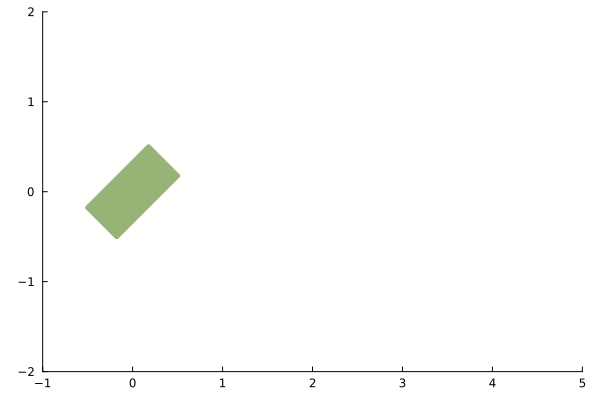

In [9]:
plot(body,xlim=xlim,ylim=ylim)

### Construct the system structure
This step is like the previous notebook, but now we also provide the body as an argument. It is important
to note that we have not provided any explicit information about the boundary conditions on our shape.
It therefore assumes that we want to enforce zero velocity on the shape. We will show another
example later in which we change this. Note that we have to supply the `RigidBodyMotion`
object via the `motions` keyword.

In [10]:
sys = viscousflow_system(g,body,phys_params=my_params,motions=m);

### Initialize
Now, we initialize with zero vorticity. Note that we do this by calling
`init_sol` with no argument except for `sys` itself.

In [11]:
u0 = init_sol(sys)

(Dual nodes in a (nx = 308, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 308, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

and now create the integrator, with a long enough time span to hold the whole
solution history:

In [12]:
tspan = (0.0,20.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 308, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 308, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 1$.

In [13]:
@time step!(integrator,1.0)

  8.911435 seconds (3.66 M allocations: 1.857 GiB, 1.54% gc time, 27.36% compilation time)


### Examine
Let's look at the flow field at the end of this interval

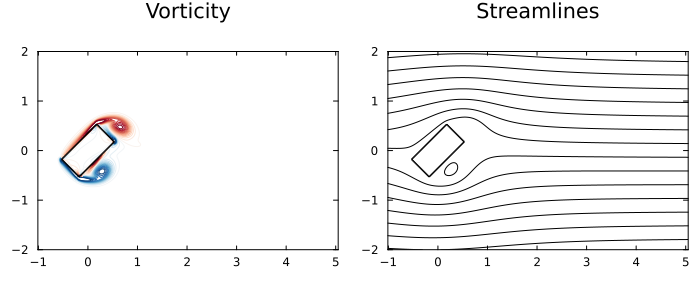

In [14]:
plot(
plot(vorticity(integrator),sys,title="Vorticity",clim=(-15,15),levels=range(-15,15,length=30), color = :RdBu,ylim=ylim),
plot(streamfunction(integrator),sys,title="Streamlines",ylim=ylim,color = :Black),
    size=(700,300)
    )

#### Compute the moment and force histories
To do this, we supply the solution history `sol`, the system `sys`, and the index
of the body (1).

In [15]:
sol = integrator.sol;
mom, fx, fy = force(sol,sys,1);

Plot the histories. Note that we are actually plotting the drag and lift
coefficient histories here:
$$ C_D = \dfrac{F_x}{\frac{1}{2}\rho U_\infty^2 L}, \quad C_L = \dfrac{F_y}{\frac{1}{2}\rho U_\infty^2 L}, \quad C_m = \dfrac{M}{\frac{1}{2}\rho U_\infty^2 L^2} $$
Since the quantities in this simulation are already scaled by $\rho$, $U_\infty$, and $L$
(because $\rho$ has been scaled out of the equations, and the free stream speed is
set to 1 and the height of the shape to 1), then we obtain these coefficients by
simply dividing by 1/2, or equivalently, by multiplying by 2:

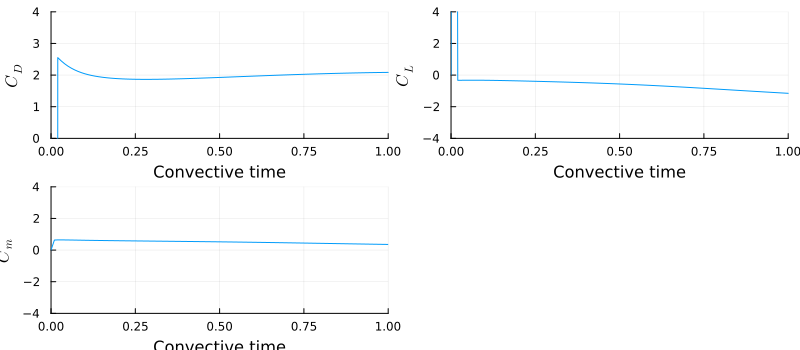

In [16]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
plot(sol.t,2*mom,xlim=(0,Inf),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)

The mean drag and lift coefficients (omitting the first two steps) are

In [17]:
meanCD = mean(2*fx[3:end])

1.9913513840395671

In [18]:
meanCL = mean(2*fy[3:end])

-0.632806199430718

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*